# <a id='toc1_'></a>[Visual Question Answering](#toc0_)

In [1]:
%pip install ftfy regex tqdm --user
%pip install pandas --user
%pip install wordcloud --user
%pip install sklearn --user
%pip install scikit-learn --user
%pip install Levenshtein --user
%pip install git+https://github.com/openai/CLIP.git --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' packag

## <a id='toc1_2_'></a>[Importing Libraries](#toc0_)

In [2]:
# Importing os, numpy and pandas for data manipulation
import os
import numpy as np 
import pandas as pd

# For data visualization, we will use matplotlib, wordcloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# For data preprocessing, we will use Counter, train_test_split, Levenshtein distance, Python Image Library and OneHotEncoder
from collections import Counter
import Levenshtein as lev
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# For saving and loading the preprocessed data, we will use pickle
import pickle

# For Building the model, we will use PyTorch and its functions
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import clip
from torch.utils.data import Dataset, DataLoader

# For taking the image from the URL, we will use requests
import requests

# For evaluation, we will need sklearn.metrics.average_precision_score
from sklearn.metrics import average_precision_score

# Importing json for results formatting which will be uploaded for evaluation
import json

## <a id='toc1_3_'></a>[Configuring the Notebook](#toc0_)

In [3]:
# Configuring the paths for the dataset
INPUT_PATH = '/kaggle/input/vizwiz'
ANNOTATIONS = INPUT_PATH + '/Annotations/Annotations'
TRAIN_PATH = INPUT_PATH + '/train/train'
VALIDATION_PATH = INPUT_PATH + '/val/val'
ANNOTATIONS_TRAIN_PATH = ANNOTATIONS + '/train.json'
ANNOTATIONS_VAL_PATH = ANNOTATIONS + '/val.json'
OUTPUT_PATH = '/kaggle/working/'
ANSWER_SPACE = 0 # Will be configured later when we build the vocab using the methodology described in the paper
MODEL_NAME = "ViT-L/14@336px" # This is the backbone of the CLIP model

# Using accelerated computing if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)

Device:  cuda


## <a id='toc1_4_'></a>[Processing Data](#toc0_)

The following cell defines functions for exploratory data analysis and preprocessing of data
- `read_dataframe` function reads a JSON file and returns a dataframe with required columns
- `split_train_test` function splits the dataframe into train and test sets
- `plot_histogram`, `plot_pie`, and `plot_wordcloud` functions plot the histogram, pie chart, and wordcloud of the given column, respectively
- `explore_dataframe` function explores the dataframe by utilizing the previous functions
- `get_number_of_distinct_answers` function returns the number of distinct answers in the dataframe
- `process_images` function processes the images in the dataframe and returns the image features using Open AI's CLIP model
- `process_questions` function processes the questions in the dataframe and returns the question features using Open AI's CLIP model

In [4]:
def read_dataframe(path):
    """
    Reads the JSON file and returns a dataframe with the required columns (image, question, answers, answer_type, answerable)

    Parameters:
        path (str): Path to the JSON file

    Returns:
        df (pandas.DataFrame): Dataframe with the required columns
    """
    df = pd.read_json(path)
    df = df[['image', 'question', 'answers', 'answer_type', 'answerable']]
    return df

def split_train_test(dataframe, test_size = 0.05):
    """
    Splits the dataframe into train and test sets

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be split

    Returns:
        train (pandas.DataFrame): Train set
        test (pandas.DataFrame): Test set
    """
    train, test = train_test_split(dataframe, test_size=test_size, random_state=42, stratify=dataframe[['answer_type', 'answerable']])
    return train, test

def plot_histogram(dataframe, column):
    """
    Plots the histogram of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    plt.hist(dataframe[column])
    plt.title(column)
    plt.show()

def plot_pie(dataframe, column):
    """
    Plots the pie chart of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted
    
    Returns:
        None
    """
    value_counts = dataframe[column].value_counts()
    plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')
    plt.title(column)
    plt.show()

def plot_wordcloud(dataframe, column):
    """
    Plots the wordcloud of the given column

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be plotted
        column (str): Column to be plotted

    Returns:
        None
    """
    text = " ".join([word for word in dataframe[column]])

    wordcloud = WordCloud(width = 800, height = 800, 
                    background_color ='white', 
                    min_font_size = 10).generate(text) 
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()

def explore_dataframe(dataframe):
    """
    Explores the dataframe (EDA) by plotting the pie charts, histograms and wordclouds of the columns

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        None
    """
    plot_pie(dataframe, 'answer_type')
    plot_pie(dataframe, 'answerable')
    plot_histogram(dataframe, 'answerable')
    plot_wordcloud(dataframe, 'question')
    
def get_number_of_distinct_answers(dataframe):
    """
    Returns the number of distinct answers in the dataframe

    Parameters:
        dataframe (pandas.DataFrame): Dataframe to be explored

    Returns:
        len(unique_answers_set) (int): Number of distinct answers in the dataframe
    """
    unique_answers_set = set()
    for row in dataframe['answers']:
        for answer_map in row:
            unique_answers_set.add(answer_map['answer'])
    return len(unique_answers_set)

def process_images(dataframe, image_path, clip_model, preprocessor, device):
    """
    Processes the images in the dataframe and returns the image features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the images
        image_path (str): Path to the input images
        clip_model (clip.model.CLIP): CLIP model
        preprocessor (clip.model.Preprocess): Preprocessor for the CLIP model
        device (torch.device): Device to be used for processing
    
    Returns:
        images (list): List of image features
    """
    images = []
    for _, row in dataframe.iterrows():
        full_path = image_path + "/" + row['image']
        image = Image.open(full_path)
        image = preprocessor(image).unsqueeze(0).to(device)
        image_features = clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)
        images.append(image_features)
    return images

def process_questions(dataframe, clip_model,device):
    """
    Processes the questions in the dataframe and returns the question features

    Parameters:
        dataframe (pandas.DataFrame): Dataframe containing the questions
        clip_model (clip.model.CLIP): CLIP model
        device (torch.device): Device to be used for processing

    Returns:
        questions (list): List of question features
    """
    questions = []
    for _, row in dataframe.iterrows():
        question = row['question']
        question =  clip.tokenize(question).to(device)
        text_features = clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)
        questions.append(text_features)
    return questions

## <a id='toc1_5_'></a>[Creating Dataframes & Splitting](#toc0_)

Now, let's use previously defined functions to create dataframes and split them into train and test sets.

In [5]:
train_df = read_dataframe(ANNOTATIONS_TRAIN_PATH)
validation_df = read_dataframe(ANNOTATIONS_VAL_PATH)
train_df, test_df = split_train_test(train_df, test_size=0.05)
ANSWER_SPACE = get_number_of_distinct_answers(train_df) # The answer space will be decreased later when we process the answers
print("Number of distinct answers: ", ANSWER_SPACE)

Number of distinct answers:  39515


## <a id='toc1_6_'></a>[Exploratory Data Analysis](#toc0_)

### <a id='toc1_6_1_'></a>[Training Dataframe](#toc0_)

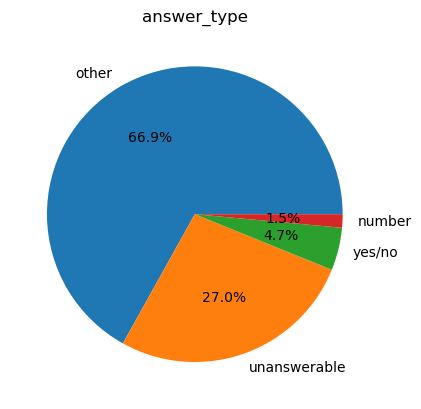

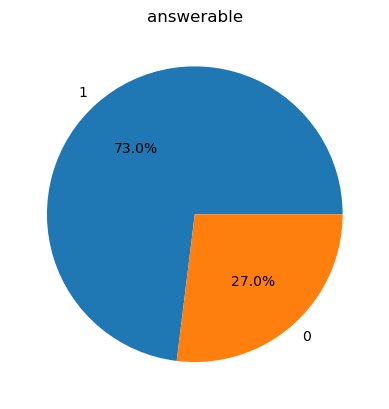

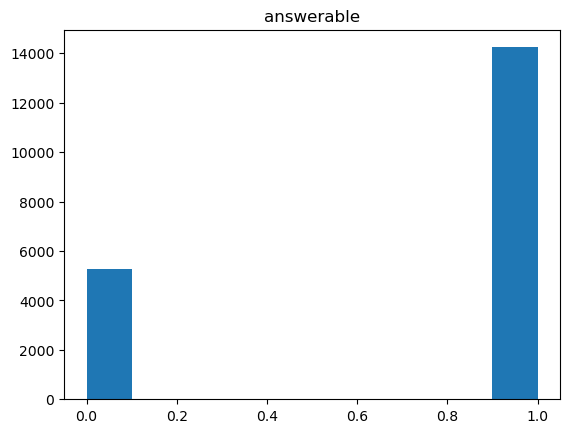

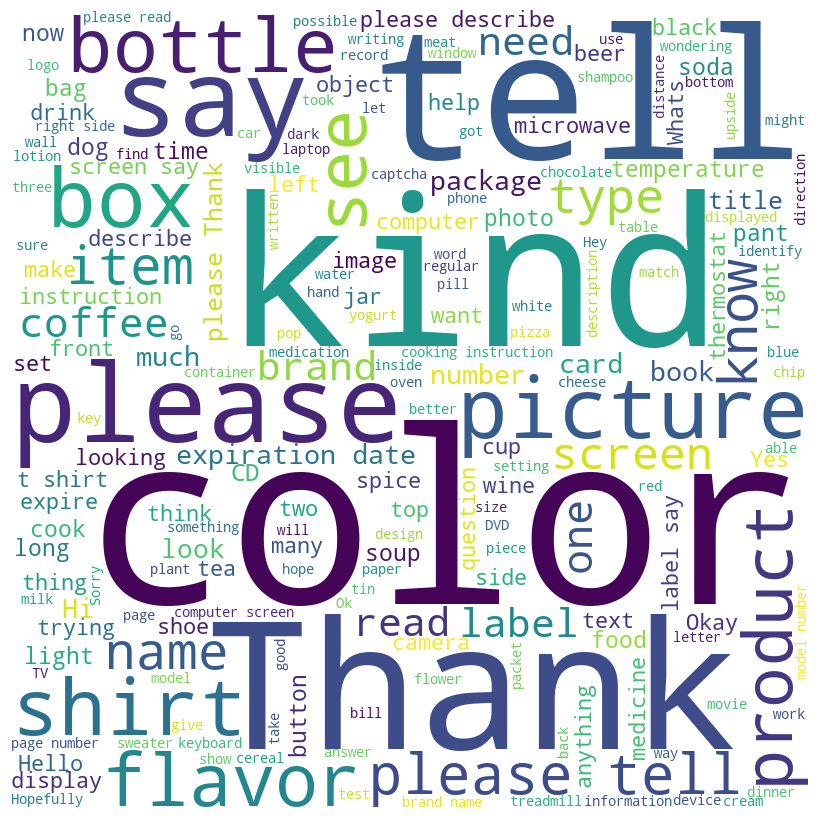

Number of distinct answers:  39515
Number of samples in train:  19496


In [6]:
explore_dataframe(train_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(train_df))
print("Number of samples in train: ", len(train_df))

### <a id='toc1_6_2_'></a>[Validation Dataframe](#toc0_)

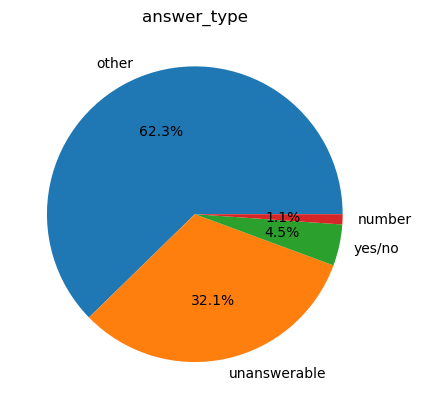

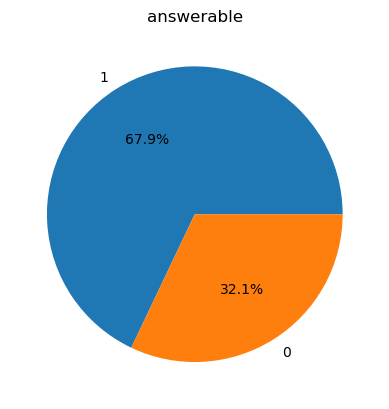

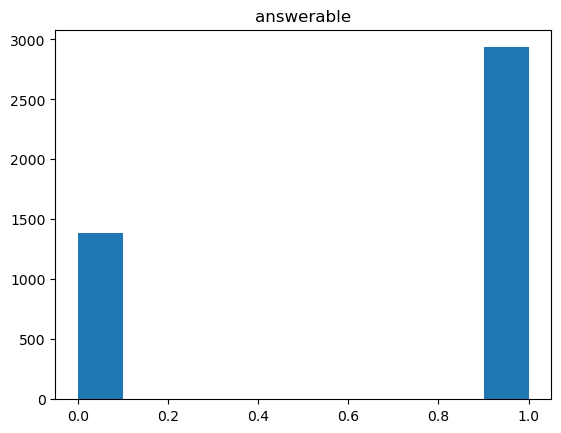

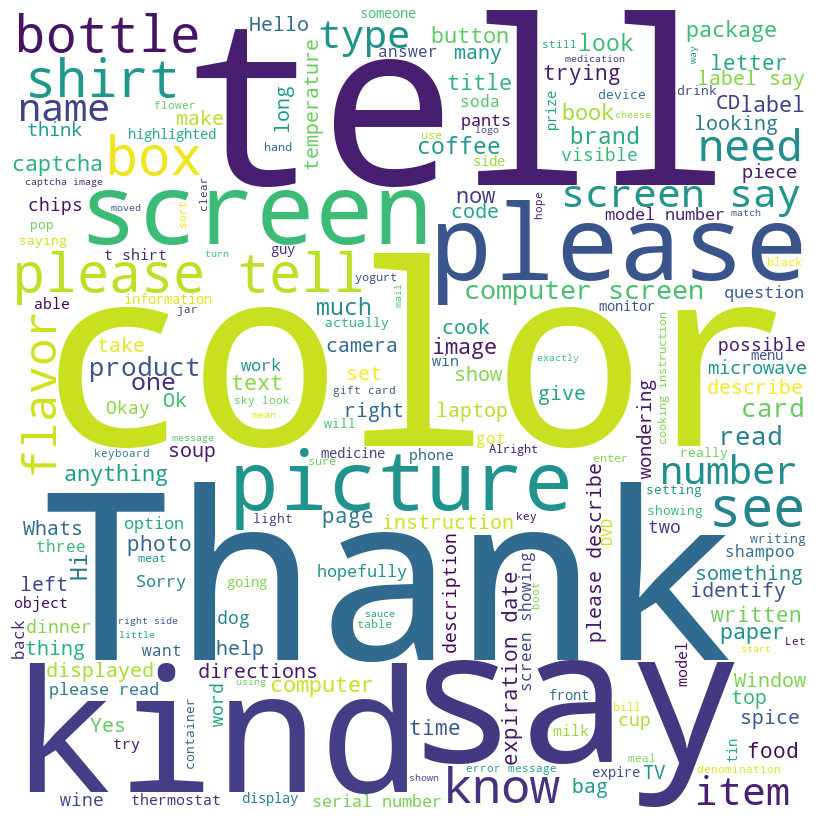

Number of distinct answers:  10905
Number of samples in validation set:  4319


In [7]:
explore_dataframe(validation_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(validation_df))
print("Number of samples in validation set: ", len(validation_df))

### <a id='toc1_6_3_'></a>[Testing Dataframe](#toc0_)

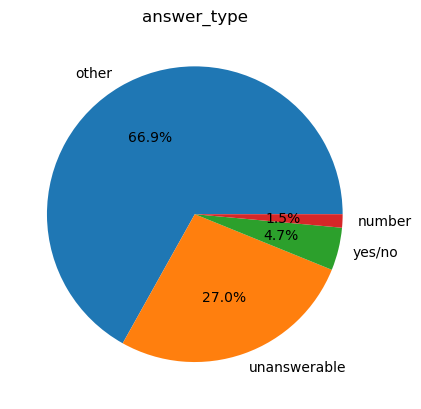

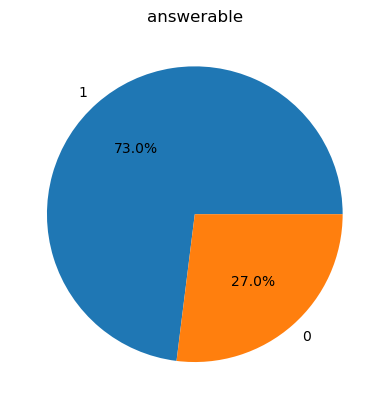

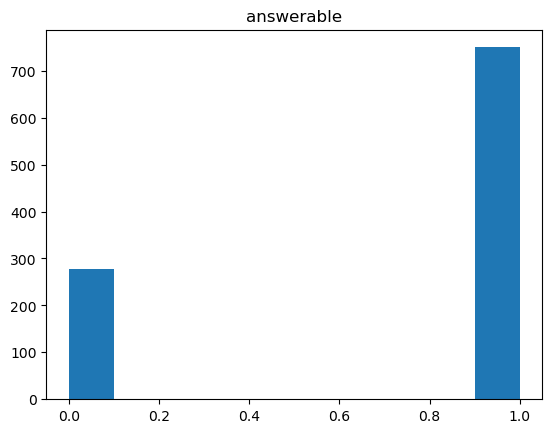

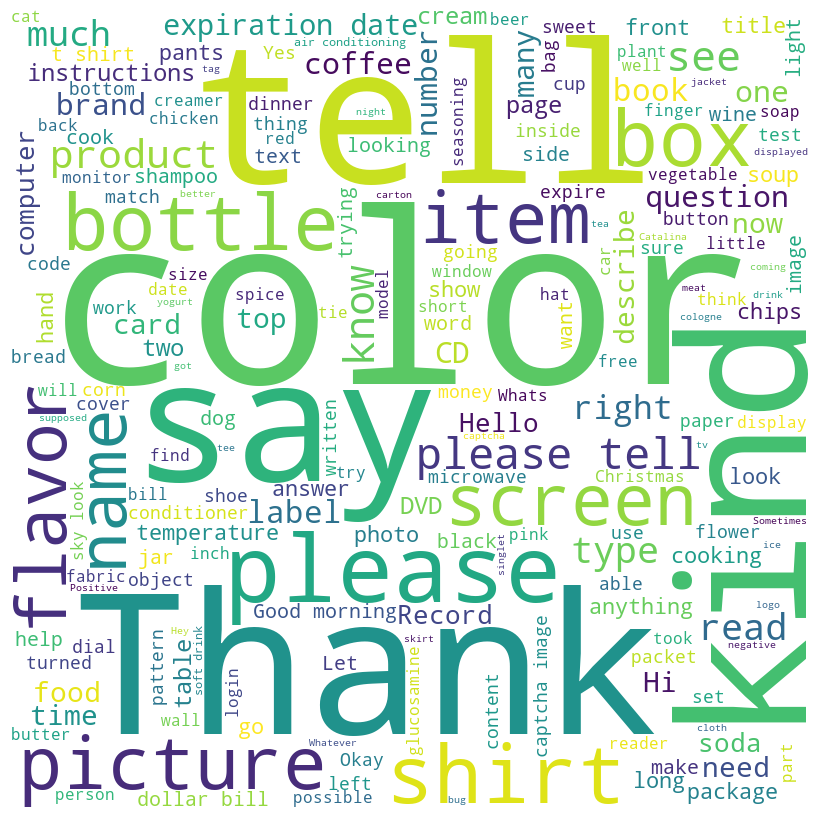

Number of distinct answers:  3007
Number of samples in test:  1027


In [8]:
explore_dataframe(test_df)
print("Number of distinct answers: ", get_number_of_distinct_answers(test_df))
print("Number of samples in test: ", len(test_df))

## <a id='toc1_7_'></a>[Processing Images & Questions using CLIP model](#toc0_)

Instead of lazy processing of images and questions embeddings and recomputing them over and over during forward passes in the model, we can preprocess them and save them in a file using Pickle. This will save us a lot of time when we want to train our model and decrease the time taken by one epoch drastically.

In [9]:
clip_model, preprocessor = clip.load(MODEL_NAME, device = DEVICE)
clip_model.eval().requires_grad_(False)

training_images = process_images(train_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
training_questions = process_questions(train_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'training_images.pkl', 'wb') as f:
    pickle.dump(training_images, f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'wb') as f:
    pickle.dump(training_questions, f)

validation_images = process_images(validation_df, VALIDATION_PATH, clip_model, preprocessor, DEVICE)
validation_questions = process_questions(validation_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'validation_images.pkl', 'wb') as f:
    pickle.dump(validation_images, f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'wb') as f:
    pickle.dump(validation_questions, f)

test_images = process_images(test_df, TRAIN_PATH, clip_model, preprocessor, DEVICE)
test_questions = process_questions(test_df, clip_model, DEVICE)
with open(OUTPUT_PATH + 'test_images.pkl', 'wb') as f:
    pickle.dump(test_images, f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'wb') as f:
    pickle.dump(test_questions, f)

100%|████████████████████████████████████████| 891M/891M [00:05<00:00, 161MiB/s]


## <a id='toc1_8_'></a>[Creating Dataset Class](#toc0_)

Using PyTorch requires using Dataset class. We will create a class that will be used to load the data and process it during training. We will also use this class to load the preprocessed images and questions embeddings.

In [10]:
class VizWizDataset(Dataset):
    def __init__(self, dataframe, answer_type_onehotencoder = None, answer_onehotencoder = None, model_name = "RN50x64", images_features = torch.tensor([]), questions_features = torch.tensor([])):
        super(VizWizDataset, self).__init__()

        # Total counter for all answers before filtering, used in Tie Breaking when building the answer vocabulary
        self.answer_counter = Counter() 

        # Saving image & question embeddings
        self.images_features = images_features
        self.questions_features = questions_features
        self.answerable = dataframe['answerable'].to_numpy()
        
        # Saving the dataframe
        self.dataframe = dataframe

        # List for answers for each question (each question has 10 answers)
        self.answer_counter_per_question = []

        # Populating the counter for words in answers which will be used when building answer vocabulary
        self.build_answer_counter()

        # Building the answer vocabulary according to the methodology explained in the paper
        self.build_answer_vocab()

        # The number of vocabulary words after filtering
        print("Number of distinct answers: ", len(self.get_answer_vocab()))

        # One hot encoding the answers
        if answer_type_onehotencoder is None:
            answer_type_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_type_onehotencoder.fit(self.copied_dataframe[['answer_type']])
        
        # One hot encoding the answer types
        if answer_onehotencoder is None:
            answer_onehotencoder = OneHotEncoder(handle_unknown='ignore')
            answer_onehotencoder.fit(self.copied_dataframe[['answer']])
        
        # Saving the one hot encoders
        self.answer_onehotencoder = answer_onehotencoder
        self.answer_type_onehotencoder = answer_type_onehotencoder

        # Transforming the answers and answer types to one hot encoded vectors
        self.answer_onehotencoded = answer_onehotencoder.transform(self.copied_dataframe[['answer']]).toarray()
        self.answer_type_onehotencoded = answer_type_onehotencoder.transform(self.copied_dataframe[['answer_type']]).toarray()
        
        # Saving the answer categories (vocabulary) which will be used when getting index of the predicted answer
        self.answers_categories = self.answer_onehotencoder.categories_[0].tolist()
        
        # Saving answers for each question (each question has 10 answers)
        self.build_answer_counter_per_question()
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        answer = torch.tensor(self.answer_onehotencoded[index], dtype=torch.float32)
        answer_type = torch.tensor(self.answer_type_onehotencoded[index], dtype=torch.float32)
        answer_counter = torch.tensor(self.answer_counter_per_question[index], dtype=torch.long)
        answerable = torch.tensor(self.answerable[index], dtype=torch.float32)
        return self.images_features[index], self.questions_features[index], answer, answer_type, answer_counter, answerable

    def build_answer_counter_per_question(self):

        for index, row in self.dataframe.iterrows():
            temp_list = []
            for answer_map in row['answers']:
                answer = answer_map['answer']
                # check if answer in self.answers_categories
                if answer in self.answers_categories:
                    answer_index = self.answers_categories.index(answer)
                    temp_list.append(answer_index)
            # Torch.tensor requires the all the lists to have constant length, so we pad the list with -1 if needed
            while len(temp_list) < 10:
                temp_list.append(-1)
            self.answer_counter_per_question.append(temp_list)

                    
    
    def build_answer_vocab(self):
        # Building answer vocab follow this policy:
        # for each question we have 10 answers, we choose the most frequent answer as the answer for this question
        # if there is a tie, we choose the most common one in the whole dataset
        # if there is a tie, we choose the pairwise Levenshtein distance is used to find the answer that is most representative to all others.
        
        # Copying the original dataframe which will be manipulated
        self.copied_dataframe = self.dataframe.copy()
        self.copied_dataframe.drop(columns=['answers'], inplace=True)

        # Adding extra column named 'answer'
        self.copied_dataframe['answer'] = None

        for index, row in self.dataframe.iterrows():
            intermediate_counter = Counter()
            for answer_map in row['answers']:
                answer = answer_map['answer']
                intermediate_counter.update([answer])
            
            # let's see the top elements in the answers_counter to check if there is a tie
            top_elements = intermediate_counter.most_common(1)
            if len(top_elements) == 1:
                self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
            else:
                # let's see who is the most common answer in the whole dataset
                top_elements = self.answer_counter.most_common(1)
                if len(top_elements) == 1:
                    self.copied_dataframe.at[index, 'answer'] = top_elements[0][0]
                else:
                    # let's get the minimum levenshtein distance between the answers in top_elements
                    current_min = np.inf
                    current_answer = None
                    for answer in top_elements:
                        total_distance = 0
                        for answer2 in top_elements:
                            if answer != answer2:
                                lev_distance = lev.distance(answer[0], answer2[0])
                                total_distance += lev_distance
                        if total_distance < current_min:
                            current_min = total_distance
                            current_answer = answer[0]
                    self.copied_dataframe.at[index, 'answer'] = current_answer
        return

    def build_answer_counter(self):
        for row in self.dataframe['answers']:
            for answer_map in row:
                self.answer_counter.update([answer_map['answer']])
    
    def get_answer_vocab(self):
        return self.copied_dataframe['answer'].unique()

## <a id='toc1_9_'></a>[Building Model's Architecture](#toc0_)

Now, let's build our model's architecture according to the paper. We will use PyTorch to build our model as we said before.

In [21]:
class VQAModel(nn.Module):

    def __init__(self, num_classes, hidden_size, model_name = "ViT-L/14@336px", device = torch.device("cpu")):
        super(VQAModel, self).__init__()

        self.training_losses = []
        self.validation_losses = []

        self.training_accuracies = []
        self.validation_accuracies = []

        self.vizwiz_training_accuracies = []
        self.vizwiz_validation_accuracies = []

        self.training_answerability = []
        self.validation_answerability = []
        
        self.device = device
        self.model_name = model_name
        
        # Initializing Binary Cross Entropy Loss which will be used to train the model on answerability
        self.answerability_loss_fn = nn.BCELoss()
        
        # Loading the CLIP model
        self.clip_model, self.preprocess = clip.load(model_name, device = device)
        
        # Freezing the CLIP model
        for param in self.clip_model.parameters():
            param.requires_grad = False

        # First linear layer
        self.linear_layer1 = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Dropout(p=0.5),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Second linear layer
        self.linear_layer2 = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, num_classes) 
        )

        self.answer_type_layer = nn.Linear(hidden_size, 4)
        self.answer_mask_layer = nn.Linear(4, num_classes)

        self.sigmoid = nn.Sigmoid()

        # Answerability Linear Layer (We removed drop out layer because training answerability was very bad)
        self.answerability_linear_layer = nn.Sequential(
            nn.LayerNorm(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1]),
            nn.Linear(self.clip_model.visual.output_dim + self.clip_model.text_projection.shape[1], hidden_size)
        )

        # Answerability Sigmoid Layer
        self.answerability_final_layer = nn.Linear(hidden_size, 1)

        # Sigmoid Layer for Answerability
        self.answerability_sigmoid = nn.Sigmoid()

    def forward(self, image, question):

        # Flattening and concatenating the image and question features
        image = torch.flatten(image, start_dim=1)
        question = torch.flatten(question, start_dim=1)
        features = torch.cat((image, question), dim=1)
        
        # Calculating the answerability score
        answerability_score = self.answerability_linear_layer(features)
        answerability_score = self.answerability_final_layer(answerability_score)
        answerability_score = self.answerability_sigmoid(answerability_score)
        answerability_score = answerability_score.squeeze()
        
        # Passing the features through the first linear layer
        features = self.linear_layer1(features)

        # Passing the features to get 4 answer types
        answer_type = self.answer_type_layer(features)

        # Expanding answer make to the same size as the number of classes (vocab size)
        answer_mask = self.answer_mask_layer(answer_type)

        # Applying sigmoid to get the answer mask
        answer_mask = self.sigmoid(answer_mask)

        # Passing the features through the second linear layer
        output = self.linear_layer2(features)

        # Applying the answer mask to the output
        output = output * answer_mask
        
        return output, answer_type, answerability_score
    
    def train_model(self, training_dataloader, validation_dataloader, test_dataloader, criterion, optimizer, epochs = 10, save_path = None, save_every = 1):
        for epoch in range(1,epochs+1):
            training_loss, training_accuracy, training_vizwiz_accuracy, train_answerability_score = self.training_step(training_dataloader, criterion, optimizer, self.device)
            validation_loss, validation_accuracy, validation_vizwiz_accuracy, validation_answerability_score = self.validation_step(validation_dataloader, criterion, self.device)
            test_accuracy, test_vizwiz_accuracy, test_answerability_score = self.test_step(test_dataloader)

            self.training_losses.append(training_loss)
            self.validation_losses.append(validation_loss)

            self.training_accuracies.append(training_accuracy)
            self.validation_accuracies.append(validation_accuracy)

            self.vizwiz_training_accuracies.append(training_vizwiz_accuracy)
            self.vizwiz_validation_accuracies.append(validation_vizwiz_accuracy)

            self.training_answerability.append(train_answerability_score)
            self.validation_answerability.append(validation_answerability_score)
            
            
            print("Epoch: {} | Training Loss: {:.3f} | Validation Loss: {:.3f}".format(epoch, training_loss, validation_loss))
            print("Epoch: {} | Training Accuracy: {:.3f} | Validation Accuracy: {:.3f} | Test Accuracy: {:.3f}".format(epoch, training_accuracy, validation_accuracy, test_accuracy))
            print("Epoch: {} | Training VizWiz Accuracy: {:.3f} | Validation VizWiz Accuracy: {:.3f} | Test VizWiz Accuracy: {:.3f}".format(epoch, training_vizwiz_accuracy, validation_vizwiz_accuracy, test_vizwiz_accuracy))
            print("Epoch: {} | Training Answerability Score: {:.3f} | Validation Answerability Score: {:.3f} | Test Answerability Score: {:.3f}\n".format(epoch, train_answerability_score, validation_answerability_score, test_answerability_score))
            
            if save_path != None and epoch % save_every == 0:
                self.save_model(save_path + "epoch_{}.pth".format(epoch))
        return
    
    def training_step(self, dataloader, criterion, optimizer, device):
        training_loss, training_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.train()
        for _, batch in enumerate(dataloader):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
            optimizer.zero_grad()
            output, answer_type_predicted, answerable_predict = self.forward(image, question)
            answerable = 1 - answerable
            answerable_predict = 1.0 - answerable_predict
            loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            predicted_answer = torch.argmax(output, dim = 1)
            actual_answer = torch.argmax(answer, dim = 1)
            for i in range(len(answer)):
                if actual_answer[i] == predicted_answer[i]:
                    training_accuracy +=1
                total_sum +=1
                vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                answerable_true.append(answerable[i].item())
                answerable_predicted.append(answerable_predict[i].item())
        

        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)

        training_loss /= len(dataloader)
        training_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        return training_loss, training_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
            
    
    def validation_step(self, dataloader, criterion, device):
        validation_loss, validation_accuracy, vizwiz_accuracy, total_sum = 0.0, 0.0, 0.0, 0
        answerable_true = []
        answerable_predicted = []
        self.eval()
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(device), question.to(device), answer.to(device), answer_type.to(device), answers_for_questions.to(device), answerable.to(device)
                output, answer_type_predicted, answerable_predict = self.forward(image, question)
                
                # Answerablity is the confidence that quesion is not answerable, so we have to subtract from 1
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                loss = criterion(output, answer) + criterion(answer_type_predicted, answer_type) + self.answerability_loss_fn(answerable_predict, answerable)
                validation_loss += loss.item()
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if actual_answer[i] == predicted_answer[i]:
                        validation_accuracy += 1
                    total_sum +=1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
                    
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        validation_loss /= len(dataloader)
        validation_accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        
        # We will use weighted average since that there is imbalance in answerability in the dataset as displayed in EDA section
        return validation_loss, validation_accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')
    
    def test_step(self, dataloader):
        self.eval()
        accuracy, total_sum, vizwiz_accuracy = 0.0, 0, 0.0
        answerable_true = []
        answerable_predicted = []
        with torch.no_grad():
            for _, batch in enumerate(dataloader):
                image, question, answer, answer_type, answers_for_questions, answerable = batch
                image, question, answer, answer_type, answers_for_questions, answerable = image.to(self.device), question.to(self.device), answer.to(self.device), answer_type.to(self.device), answers_for_questions.to(self.device), answerable.to(self.device)
                output, _, answerable_predict = self.forward(image, question)
                answerable = 1 - answerable
                answerable_predict = 1.0 - answerable_predict
                predicted_answer = torch.argmax(output, dim = 1)
                actual_answer = torch.argmax(answer, dim = 1)
                for i in range(len(answer)):
                    if torch.sum(answer[i]) == 0:
                        continue
                    if predicted_answer[i] == actual_answer[i]:
                        accuracy += 1
                    vizwiz_accuracy += min(1, torch.sum(torch.eq(predicted_answer[i], answers_for_questions[i])).item()/3)
                    total_sum +=1
                    answerable_true.append(answerable[i].item())
                    answerable_predicted.append(answerable_predict[i].item())
            
        answerable_true = np.array(answerable_true)
        answerable_predicted = np.array(answerable_predicted)
        
        accuracy /= total_sum
        vizwiz_accuracy /= total_sum
        return accuracy, vizwiz_accuracy, average_precision_score(answerable_true, answerable_predicted, average = 'weighted')

    def save_model(self, path):
        """
        Saves the model state dictionary to the given path.

        Args:
        - self: the model object
        - path (str): the path to save the model state dictionary

        Returns:
        - None
        """
        torch.save(self.state_dict(), path)

    def load_model(self, path):
        """
        Loads the model state dictionary from the given path.

        Args:
        - self: the model object
        - path (str): the path to load the model state dictionary

        Returns:
        - self: the loaded model object
        """
        self.load_state_dict(torch.load(path))
        self.eval()
        return self

    def predict(self, image, question):
        """
        Predicts the output and answer type for the given image and question.

        Args:
        - self: the model object
        - image (tensor): the image tensor
        - question (tensor): the question tensor

        Returns:
        - output (tensor): the predicted output tensor
        - answer_type (str): the predicted answer type
        """
        output, answer_type, answerability = self.forward(image, question)
        answerability = 1.0 - answerability
        return output, answer_type, answerability

    def plot_loss(self):
        """
        Plots the training and validation losses.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_losses, label = "Training Loss")
        plt.plot(self.validation_losses, label = "Validation Loss")
        plt.legend()
        plt.show()

    def plot_accuracy(self):
        """
        Plots the training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_accuracies, label = "Training Accuracy")
        plt.plot(self.validation_accuracies, label = "Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_vizwiz_accuracy(self):
        """
        Plots the VizWiz training and validation accuracies.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.vizwiz_training_accuracies, label = "VizWiz Training Accuracy")
        plt.plot(self.vizwiz_validation_accuracies, label = "VizWiz Validation Accuracy")
        plt.legend()
        plt.show()

    def plot_answerability(self):
        """
        Plots the training and validation answerabilities.

        Args:
        - self: the model object

        Returns:
        - None
        """
        plt.plot(self.training_answerability, label = "Training Answerability")
        plt.plot(self.validation_answerability, label = "Validation Answerability")
        plt.legend()
        plt.show()

    def test_model(self, image_path, question):
        """
        Tests the model by predicting the answer and answer type for the given image and question.

        Args:
        - self: the model object
        - image_path (str): the path to the image file or URL
        - question (str): the question to be asked

        Returns:
        - predicted_answer (tensor): the predicted answer tensor
        - predicted_answer_type (str): the predicted answer type
        """
        self.eval()
        if image_path.startswith("http"):
            image = Image.open(requests.get(image_path, stream = True).raw)
        else:
            image = Image.open(image_path)

        image = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.clip_model.encode_image(image)
        image_features = torch.flatten(image_features, start_dim=1)

        question =  clip.tokenize(question).to(self.device)
        text_features = self.clip_model.encode_text(question).float()
        text_features = torch.flatten(text_features, start_dim=1)

        predicted_answer, predicted_answer_type, answerability = self.predict(image_features, text_features)
        return predicted_answer, predicted_answer_type, answerability

    def print_CLIP_model(self):
        """
        Prints the details of the selected CLIP model.

        Args:
        - self: the model object

        Returns:
        - None
        """
        input_resolution = self.clip_model.visual.input_resolution
        context_length = self.clip_model.context_length
        vocab_size = self.clip_model.vocab_size

        print("Selected model:", self.model_name)
        print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in self.clip_model.parameters()]):,}")
        print("Input resolution:", input_resolution)
        print("Context length:", context_length)
        print("Vocab size:", vocab_size)
        print("")

## <a id='toc1_10_'></a>[Loading Preprocessed Embeddings](#toc0_)

In [12]:
with open(OUTPUT_PATH + 'training_images.pkl', 'rb') as f:
    training_images = pickle.load(f)
with open(OUTPUT_PATH + 'training_questions.pkl', 'rb') as f:
    training_questions = pickle.load(f)

with open(OUTPUT_PATH + 'validation_images.pkl', 'rb') as f:
    validation_images = pickle.load(f)
with open(OUTPUT_PATH + 'validation_questions.pkl', 'rb') as f:
    validation_questions = pickle.load(f)

with open(OUTPUT_PATH + 'test_images.pkl', 'rb') as f:
    test_images = pickle.load(f)
with open(OUTPUT_PATH + 'test_questions.pkl', 'rb') as f:
    test_questions = pickle.load(f)

## <a id='toc1_11_'></a>[Preparing Data Loaders](#toc0_)

In [13]:
# Constructing the training dataset
training_dataset = VizWizDataset(train_df, None, None, MODEL_NAME, training_images, training_questions)
ANSWER_ONEHOTENCODER = training_dataset.answer_onehotencoder
ANSWER_TYPE_ONEHOTENCODER = training_dataset.answer_type_onehotencoder

# Saving the fitted one hot encoders
with open(OUTPUT_PATH + 'answer_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_ONEHOTENCODER, f)
with open(OUTPUT_PATH + 'answer_type_onehotencoder.pkl', 'wb') as f:
    pickle.dump(ANSWER_TYPE_ONEHOTENCODER, f)

# Constructing the validation dataset
validation_dataset = VizWizDataset(validation_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, validation_images, validation_questions)

# Constructing the test dataset
test_dataset = VizWizDataset(test_df, ANSWER_TYPE_ONEHOTENCODER, ANSWER_ONEHOTENCODER, MODEL_NAME, test_images, test_questions)

# Configuring the data loaders
BATCH_SIZE = 32 # 64 is good too but 32 is better (variance wise)

# Constructing the training, validation and test data loaders
training_dataloader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

Number of distinct answers:  5410
Number of distinct answers:  1531
Number of distinct answers:  489


## <a id='toc1_12_'></a>[Training the Model](#toc0_)

Selected model: ViT-L/14@336px
Model parameters: 427,944,193
Input resolution: 336
Context length: 77
Vocab size: 49408

Epoch: 1 | Training Loss: 6.970 | Validation Loss: 4.072
Epoch: 1 | Training Accuracy: 0.233 | Validation Accuracy: 0.321 | Test Accuracy: 0.333
Epoch: 1 | Training VizWiz Accuracy: 0.361 | Validation VizWiz Accuracy: 0.447 | Test VizWiz Accuracy: 0.483
Epoch: 1 | Training Answerability Score: 0.698 | Validation Answerability Score: 0.814 | Test Answerability Score: 0.802

Epoch: 2 | Training Loss: 6.195 | Validation Loss: 3.743
Epoch: 2 | Training Accuracy: 0.268 | Validation Accuracy: 0.355 | Test Accuracy: 0.381
Epoch: 2 | Training VizWiz Accuracy: 0.391 | Validation VizWiz Accuracy: 0.488 | Test VizWiz Accuracy: 0.531
Epoch: 2 | Training Answerability Score: 0.751 | Validation Answerability Score: 0.807 | Test Answerability Score: 0.796

Epoch: 3 | Training Loss: 5.635 | Validation Loss: 3.501
Epoch: 3 | Training Accuracy: 0.303 | Validation Accuracy: 0.391 | Tes

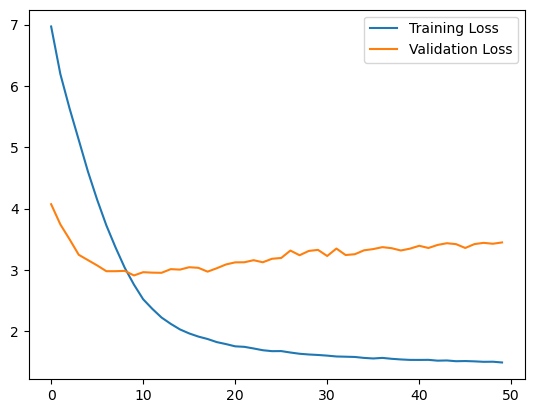

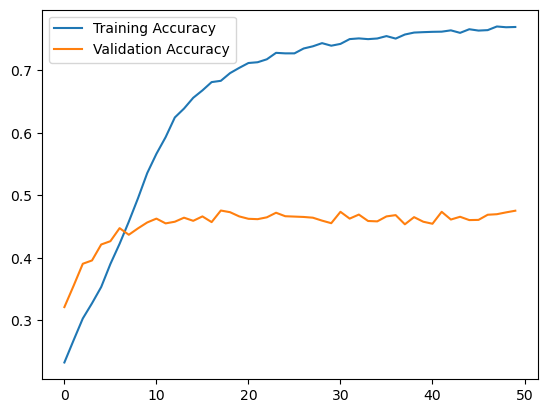

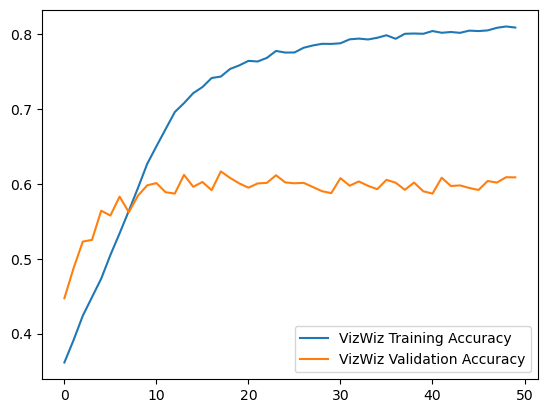

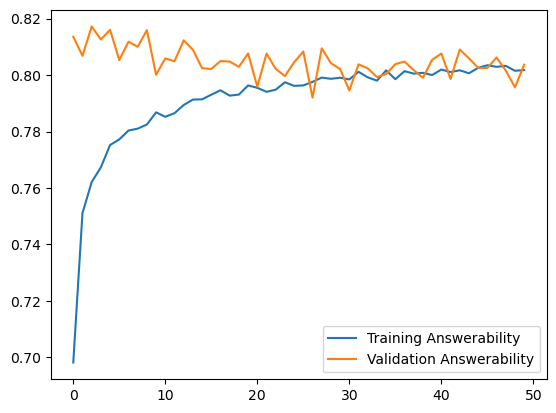

In [14]:
# Configuring training's hyperparameters
NUM_EPOCHS = 50
LR = 5e-4
WEIGHT_DECAY = 0
NUM_CLASSES = len(training_dataset.get_answer_vocab())
SAVE_PATH = OUTPUT_PATH
SAVE_EVERY = 5

# Initializing the model
model = VQAModel(num_classes=NUM_CLASSES, device= DEVICE, hidden_size=512, model_name=MODEL_NAME).to(DEVICE)
model.print_CLIP_model()

# Initializing the loss function and optimizer
loss_function = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay = WEIGHT_DECAY)

# Training the model and plotting the loss and accuracy
model.train_model(training_dataloader, validation_dataloader, test_dataloader, loss_function, optimizer, epochs=NUM_EPOCHS, save_path=SAVE_PATH, save_every=SAVE_EVERY)
model.plot_loss()
model.plot_accuracy()
model.plot_vizwiz_accuracy()
model.plot_answerability()

In [15]:
import os

ckpt_path = "/kaggle/working/epoch_45.pth"

print("Checkpoint exists?", os.path.exists(ckpt_path))
print("Files in working dir:", os.listdir("/kaggle/working/")[:20])

NUM_CLASSES = len(training_dataset.get_answer_vocab())

model = VQAModel(
    num_classes=NUM_CLASSES,
    device=DEVICE,
    hidden_size=512,
    model_name=MODEL_NAME
).to(DEVICE)

model.load_model(ckpt_path)
print("✅ Model loaded successfully")


Checkpoint exists? True
Files in working dir: ['epoch_20.pth', 'epoch_25.pth', 'validation_images.pkl', 'epoch_5.pth', 'epoch_40.pth', 'epoch_10.pth', 'epoch_35.pth', '.virtual_documents', 'epoch_50.pth', 'test_questions.pkl', 'epoch_30.pth', 'epoch_45.pth', 'validation_questions.pkl', 'answer_type_onehotencoder.pkl', 'epoch_15.pth', 'answer_onehotencoder.pkl', 'test_images.pkl', 'training_images.pkl', 'training_questions.pkl']
✅ Model loaded successfully


In [16]:
import numpy as np
import torch
from tqdm import tqdm

def collect_answerability(model, dataloader, device):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Collecting answerability"):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image = image.to(device)
            question = question.to(device)
            answerable = answerable.to(device)

            _, _, prob_unanswerable = model.forward(image, question)  # your model returns sigmoid prob
            # Your code flips: answerable_predict = 1 - prob_unanswerable
            prob_answerable = 1.0 - prob_unanswerable

            all_probs.append(prob_answerable.detach().cpu().numpy())
            all_labels.append(answerable.detach().cpu().numpy())  # 1=answerable, 0=unanswerable (from dataset)

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    return all_probs, all_labels

val_prob_answerable, val_answerable_true = collect_answerability(model, validation_dataloader, DEVICE)

print("Collected:", len(val_prob_answerable), "samples")
print("Prob range:", val_prob_answerable.min(), "to", val_prob_answerable.max())


Collected: 4319 samples
Prob range: 9.4771385e-05 to 0.9996267


ECE (before calibration): 0.6552


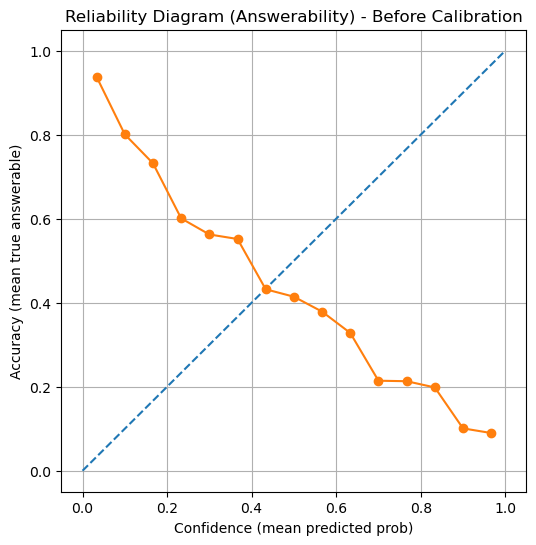

In [17]:
import matplotlib.pyplot as plt

def expected_calibration_error(probs, labels, n_bins=15):
    """
    probs: predicted probability of answerable (0..1)
    labels: ground truth answerable (0/1)
    """
    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    bin_accs, bin_confs, bin_counts = [], [], []
    
    for i in range(n_bins):
        lo, hi = bins[i], bins[i+1]
        mask = (probs >= lo) & (probs < hi)
        if mask.sum() == 0:
            bin_accs.append(0)
            bin_confs.append(0)
            bin_counts.append(0)
            continue
        
        bin_prob = probs[mask]
        bin_lab = labels[mask]
        acc = bin_lab.mean()
        conf = bin_prob.mean()
        count = mask.sum()
        
        ece += (count / len(probs)) * abs(acc - conf)
        bin_accs.append(acc)
        bin_confs.append(conf)
        bin_counts.append(count)
    
    return ece, (bins, bin_accs, bin_confs, bin_counts)

ece_before, (bins, accs, confs, counts) = expected_calibration_error(val_prob_answerable, val_answerable_true, n_bins=15)
print("ECE (before calibration):", round(ece_before, 4))

# Reliability diagram
centers = 0.5 * (bins[:-1] + bins[1:])
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(centers, accs, marker="o")
plt.title("Reliability Diagram (Answerability) - Before Calibration")
plt.xlabel("Confidence (mean predicted prob)")
plt.ylabel("Accuracy (mean true answerable)")
plt.grid(True)
plt.show()


In [18]:
import torch
import torch.nn as nn

def fit_temperature_from_probs(probs, labels, max_iter=2000, lr=0.05):
    """
    We only have probabilities (already sigmoid outputs).
    Convert prob -> logit, then learn temperature T on logits.
    """
    eps = 1e-6
    probs = np.clip(probs, eps, 1-eps)
    logits = np.log(probs / (1 - probs))

    logits_t = torch.tensor(logits, dtype=torch.float32).view(-1,1)
    labels_t = torch.tensor(labels, dtype=torch.float32).view(-1,1)

    T = torch.tensor([1.0], dtype=torch.float32, requires_grad=True)
    opt = torch.optim.Adam([T], lr=lr)
    bce = nn.BCELoss()

    for _ in range(max_iter):
        opt.zero_grad()
        scaled = logits_t / T
        probs_scaled = torch.sigmoid(scaled)
        loss = bce(probs_scaled, labels_t)
        loss.backward()
        opt.step()

        # keep T positive
        with torch.no_grad():
            T.clamp_(min=1e-3, max=100.0)

    return float(T.detach().cpu().item())

T_opt = fit_temperature_from_probs(val_prob_answerable, val_answerable_true)
print("Optimal Temperature T:", round(T_opt, 4))

def apply_temperature(probs, T):
    eps = 1e-6
    probs = np.clip(probs, eps, 1-eps)
    logits = np.log(probs / (1 - probs))
    scaled_logits = logits / T
    return 1 / (1 + np.exp(-scaled_logits))

val_prob_answerable_cal = apply_temperature(val_prob_answerable, T_opt)

ece_after, _ = expected_calibration_error(val_prob_answerable_cal, val_answerable_true, n_bins=15)
print("ECE (after calibration):", round(ece_after, 4))


Optimal Temperature T: 13.8665
ECE (after calibration): 0.291


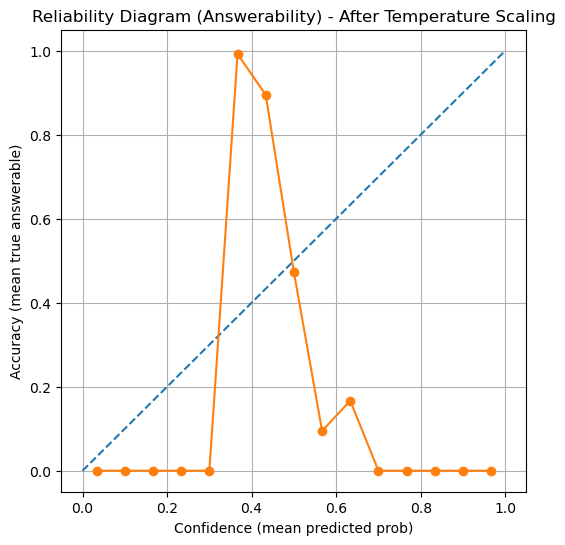

In [19]:
ece_after, (bins2, accs2, confs2, counts2) = expected_calibration_error(val_prob_answerable_cal, val_answerable_true, n_bins=15)

centers2 = 0.5 * (bins2[:-1] + bins2[1:])
plt.figure(figsize=(6,6))
plt.plot([0,1],[0,1], linestyle="--")
plt.plot(centers2, accs2, marker="o")
plt.title("Reliability Diagram (Answerability) - After Temperature Scaling")
plt.xlabel("Confidence (mean predicted prob)")
plt.ylabel("Accuracy (mean true answerable)")
plt.grid(True)
plt.show()


Eval for refusal: 100%|██████████| 135/135 [00:00<00:00, 310.61it/s]


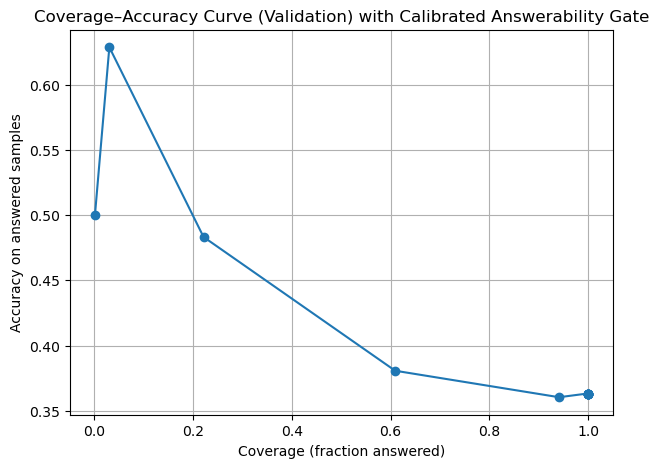

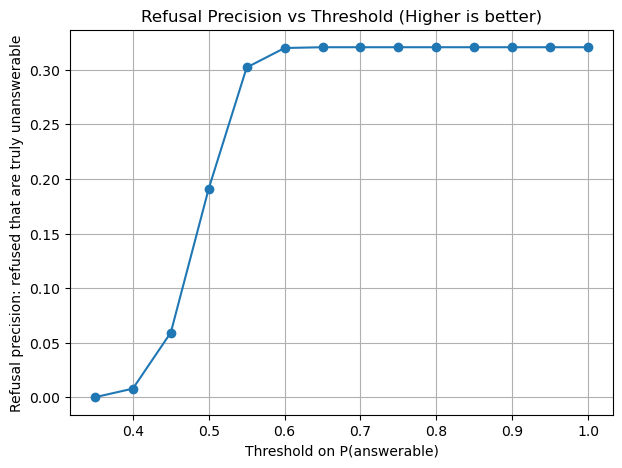

In [20]:
def evaluate_with_refusal(model, dataloader, device, T=None, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.0, 1.0, 21)

    model.eval()
    all_prob_ans = []
    all_pred_idx = []
    all_true_idx = []
    all_true_answerable = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval for refusal"):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image = image.to(device)
            question = question.to(device)

            logits, _, prob_unanswerable = model.forward(image, question)
            prob_answerable = 1.0 - prob_unanswerable

            # optional calibration
            prob_answerable = prob_answerable.detach().cpu().numpy()
            if T is not None:
                prob_answerable = apply_temperature(prob_answerable, T)

            pred_idx = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_idx = torch.argmax(answer, dim=1).detach().cpu().numpy()
            true_answerable = answerable.detach().cpu().numpy()

            all_prob_ans.append(prob_answerable)
            all_pred_idx.append(pred_idx)
            all_true_idx.append(true_idx)
            all_true_answerable.append(true_answerable)

    all_prob_ans = np.concatenate(all_prob_ans)
    all_pred_idx = np.concatenate(all_pred_idx)
    all_true_idx = np.concatenate(all_true_idx)
    all_true_answerable = np.concatenate(all_true_answerable)

    results = []
    for th in thresholds:
        keep = all_prob_ans >= th  # answered
        coverage = keep.mean()

        # accuracy only on answered samples (and only where label exists)
        if keep.sum() == 0:
            acc = np.nan
        else:
            acc = (all_pred_idx[keep] == all_true_idx[keep]).mean()

        # refusal quality: how many refused were truly unanswerable?
        refused = ~keep
        if refused.sum() == 0:
            refusal_precision = np.nan
        else:
            refusal_precision = (all_true_answerable[refused] == 0).mean()

        results.append((th, coverage, acc, refusal_precision))

    return results

thresholds = np.linspace(0.0, 1.0, 21)
res = evaluate_with_refusal(model, validation_dataloader, DEVICE, T=T_opt, thresholds=thresholds)

ths = [r[0] for r in res]
cov = [r[1] for r in res]
acc = [r[2] for r in res]
ref_prec = [r[3] for r in res]

plt.figure(figsize=(7,5))
plt.plot(cov, acc, marker="o")
plt.title("Coverage–Accuracy Curve (Validation) with Calibrated Answerability Gate")
plt.xlabel("Coverage (fraction answered)")
plt.ylabel("Accuracy on answered samples")
plt.grid(True)
plt.show()

plt.figure(figsize=(7,5))
plt.plot(ths, ref_prec, marker="o")
plt.title("Refusal Precision vs Threshold (Higher is better)")
plt.xlabel("Threshold on P(answerable)")
plt.ylabel("Refusal precision: refused that are truly unanswerable")
plt.grid(True)
plt.show()


In [23]:
# ============================================================
# NEXT BLOCK: Sanity-check label meaning + corrected refusal metrics
# ============================================================

import numpy as np
from tqdm import tqdm

def inspect_answerable_labels(dataloader, name="loader"):
    vals = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Inspecting answerable labels ({name})"):
            *_, answerable = batch
            vals.append(answerable.detach().cpu().numpy())
    vals = np.concatenate(vals)
    print(f"\n[{name}] answerable label stats:")
    print("Unique values:", np.unique(vals))
    print("Mean:", vals.mean(), " -> fraction of label==1:", (vals==1).mean(), "label==0:", (vals==0).mean())

inspect_answerable_labels(validation_dataloader, "VAL")
inspect_answerable_labels(test_dataloader, "TEST")

# IMPORTANT:
# In your TRAINING code you do:
#   answerable = 1 - answerable
#   answerable_predict = 1 - answerable_predict
# That implies the model is trained to predict something flipped.
# Let's compute BOTH interpretations and see which one matches better.

def evaluate_refusal_precision_both(label_answerable, refused_mask):
    """
    label_answerable: array from dataloader (0/1)
    refused_mask: True where model refused
    We compute precision under two interpretations:
      A) label==1 means "answerable"
      B) label==1 means "unanswerable"
    """
    # A) label==1 means answerable => truly unanswerable are label==0
    prec_A = np.nan if refused_mask.sum()==0 else (label_answerable[refused_mask] == 0).mean()

    # B) label==1 means unanswerable => truly unanswerable are label==1
    prec_B = np.nan if refused_mask.sum()==0 else (label_answerable[refused_mask] == 1).mean()

    return prec_A, prec_B


def evaluate_with_refusal_fixed(model, dataloader, device, T=None, threshold=0.45):
    model.eval()

    all_prob_ans = []
    all_pred_idx = []
    all_true_idx = []
    all_label_answerable = []
    all_answer_sum = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Eval fixed refusal (debug)"):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image = image.to(device)
            question = question.to(device)

            logits, _, prob_unanswerable = model.forward(image, question)
            prob_answerable = 1.0 - prob_unanswerable
            prob_answerable = prob_answerable.detach().cpu().numpy()

            if T is not None:
                prob_answerable = apply_temperature(prob_answerable, T)

            pred_idx = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_idx = torch.argmax(answer, dim=1).detach().cpu().numpy()

            all_prob_ans.append(prob_answerable)
            all_pred_idx.append(pred_idx)
            all_true_idx.append(true_idx)
            all_label_answerable.append(answerable.detach().cpu().numpy())
            all_answer_sum.append(torch.sum(answer, dim=1).detach().cpu().numpy())

    all_prob_ans = np.concatenate(all_prob_ans)
    all_pred_idx = np.concatenate(all_pred_idx)
    all_true_idx = np.concatenate(all_true_idx)
    all_label_answerable = np.concatenate(all_label_answerable)
    all_answer_sum = np.concatenate(all_answer_sum)

    keep = all_prob_ans >= threshold
    coverage = keep.mean()

    # accuracy only on answered + where answer vector exists (sum>0)
    valid_for_acc = keep & (all_answer_sum > 0)
    acc = np.nan if valid_for_acc.sum()==0 else (all_pred_idx[valid_for_acc] == all_true_idx[valid_for_acc]).mean()

    refused = ~keep
    prec_A, prec_B = evaluate_refusal_precision_both(all_label_answerable, refused)

    print("\n================= DEBUG @ threshold", threshold, "=================")
    print("Coverage:", round(float(coverage), 4))
    print("Answered accuracy (only valid answers):", round(float(acc), 4))
    print("Refusal precision if label==1 means ANSWERABLE (refused truly UNANSWERABLE=label0):", round(float(prec_A), 4))
    print("Refusal precision if label==1 means UNANSWERABLE (refused truly UNANSWERABLE=label1):", round(float(prec_B), 4))

    # also show average label inside refused/answered to see direction
    if refused.sum() > 0:
        print("Mean(label) among REFUSED:", round(float(all_label_answerable[refused].mean()), 4))
    if keep.sum() > 0:
        print("Mean(label) among ANSWERED:", round(float(all_label_answerable[keep].mean()), 4))

    return coverage, acc, prec_A, prec_B

# Run debug on VAL and TEST using your chosen threshold:
_ = evaluate_with_refusal_fixed(model, validation_dataloader, DEVICE, T=T_opt, threshold=float(best_th))
_ = evaluate_with_refusal_fixed(model, test_dataloader, DEVICE, T=T_opt, threshold=float(best_th))


Inspecting answerable labels (VAL): 100%|██████████| 135/135 [00:00<00:00, 651.45it/s]



[VAL] answerable label stats:
Unique values: [0. 1.]
Mean: 0.6793239  -> fraction of label==1: 0.6793239175735124 label==0: 0.3206760824264876


Inspecting answerable labels (TEST): 100%|██████████| 33/33 [00:00<00:00, 645.54it/s]



[TEST] answerable label stats:
Unique values: [0. 1.]
Mean: 0.73028237  -> fraction of label==1: 0.7302823758519961 label==0: 0.2697176241480039


Eval fixed refusal (debug): 100%|██████████| 135/135 [00:00<00:00, 337.25it/s]



================= DEBUG @ threshold 0.45 =================
Coverage: 0.6094
Answered accuracy (only valid answers): 0.4528
Refusal precision if label==1 means ANSWERABLE (refused truly UNANSWERABLE=label0): 0.0593
Refusal precision if label==1 means UNANSWERABLE (refused truly UNANSWERABLE=label1): 0.9407
Mean(label) among REFUSED: 0.9407
Mean(label) among ANSWERED: 0.5118


Eval fixed refusal (debug): 100%|██████████| 33/33 [00:00<00:00, 340.34it/s]


================= DEBUG @ threshold 0.45 =================
Coverage: 0.5463
Answered accuracy (only valid answers): 0.5684
Refusal precision if label==1 means ANSWERABLE (refused truly UNANSWERABLE=label0): 0.0343
Refusal precision if label==1 means UNANSWERABLE (refused truly UNANSWERABLE=label1): 0.9657
Mean(label) among REFUSED: 0.9657
Mean(label) among ANSWERED: 0.5348


In [24]:
# ============================================================
# FINAL BLOCK: Corrected Safety Policy Evaluation + Export JSON
# ============================================================

import json
import numpy as np

# IMPORTANT FIX:
# In this dataset: label==1 means UNANSWERABLE, label==0 means ANSWERABLE
def evaluate_policy_corrected(model, dataloader, device, T, threshold):
    model.eval()

    all_prob_ans = []
    all_pred_idx = []
    all_true_idx = []
    all_label_unanswerable = []
    all_answer_sum = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Final policy eval"):
            image, question, answer, answer_type, answers_for_questions, answerable = batch
            image = image.to(device)
            question = question.to(device)

            logits, _, prob_unanswerable = model.forward(image, question)
            prob_answerable = 1.0 - prob_unanswerable
            prob_answerable = prob_answerable.detach().cpu().numpy()

            # calibrated probability
            prob_answerable = apply_temperature(prob_answerable, T)

            pred_idx = torch.argmax(logits, dim=1).detach().cpu().numpy()
            true_idx = torch.argmax(answer, dim=1).detach().cpu().numpy()

            all_prob_ans.append(prob_answerable)
            all_pred_idx.append(pred_idx)
            all_true_idx.append(true_idx)

            # label==1 means UNANSWERABLE (confirmed)
            all_label_unanswerable.append(answerable.detach().cpu().numpy())
            all_answer_sum.append(torch.sum(answer, dim=1).detach().cpu().numpy())

    all_prob_ans = np.concatenate(all_prob_ans)
    all_pred_idx = np.concatenate(all_pred_idx)
    all_true_idx = np.concatenate(all_true_idx)
    all_label_unanswerable = np.concatenate(all_label_unanswerable)
    all_answer_sum = np.concatenate(all_answer_sum)

    keep = all_prob_ans >= threshold  # answered
    refused = ~keep

    coverage = keep.mean()

    # accuracy on answered and only when answer exists
    valid_for_acc = keep & (all_answer_sum > 0)
    answered_accuracy = np.nan if valid_for_acc.sum()==0 else (all_pred_idx[valid_for_acc] == all_true_idx[valid_for_acc]).mean()

    # refusal precision: refused samples that are truly UNANSWERABLE (label==1)
    refusal_precision = np.nan if refused.sum()==0 else (all_label_unanswerable[refused] == 1).mean()

    # refusal recall (optional, strong for thesis): among all truly unanswerable, how many were refused
    truly_unans = (all_label_unanswerable == 1)
    refusal_recall = np.nan if truly_unans.sum()==0 else (refused[truly_unans]).mean()

    return {
        "coverage": float(coverage),
        "answered_accuracy": float(answered_accuracy),
        "refusal_precision": float(refusal_precision),
        "refusal_recall": float(refusal_recall),
        "threshold": float(threshold),
        "temperature": float(T),
    }

# Use your chosen threshold (best_th) and temperature (T_opt)
VAL_REPORT = evaluate_policy_corrected(model, validation_dataloader, DEVICE, T_opt, float(best_th))
TEST_REPORT = evaluate_policy_corrected(model, test_dataloader, DEVICE, T_opt, float(best_th))

print("\n================ FINAL REPORT (Corrected Labels) ================")
print("[VAL] ", VAL_REPORT)
print("[TEST]", TEST_REPORT)

# Save policy JSON for thesis "deployable safety layer"
policy = {
    "name": "Answerability Safety Gate (Temperature + Threshold)",
    "dataset_label_meaning": {
        "label_1": "UNANSWERABLE",
        "label_0": "ANSWERABLE"
    },
    "temperature_T": float(T_opt),
    "threshold_on_P_answerable": float(best_th),
    "val_metrics": VAL_REPORT,
    "test_metrics": TEST_REPORT
}

policy_path = OUTPUT_PATH + "answerability_safety_policy.json"
with open(policy_path, "w") as f:
    json.dump(policy, f, indent=2)

print(f"\n✅ Saved safety policy JSON to: {policy_path}")


Final policy eval: 100%|██████████| 33/33 [00:00<00:00, 349.96it/s]


================ FINAL REPORT (Corrected Labels) ================
[VAL]  {'coverage': 0.6094003241491086, 'answered_accuracy': 0.4527790329868956, 'refusal_precision': 0.9407231772377, 'refusal_recall': 0.5408997955010225, 'threshold': 0.45, 'temperature': 13.866539001464844}
[TEST] {'coverage': 0.5462512171372931, 'answered_accuracy': 0.5684210526315789, 'refusal_precision': 0.9656652360515021, 'refusal_recall': 0.6, 'threshold': 0.45, 'temperature': 13.866539001464844}

✅ Saved safety policy JSON to: /kaggle/working/answerability_safety_policy.json


In [25]:
# ============================================================
# FINAL DEPLOYMENT BLOCK: Safe Inference with Refusal
# ============================================================

import json
import torch

# Load saved policy
with open("/kaggle/working/answerability_safety_policy.json", "r") as f:
    SAFETY_POLICY = json.load(f)

T_DEPLOY = SAFETY_POLICY["temperature_T"]
THRESH_DEPLOY = SAFETY_POLICY["threshold_on_P_answerable"]

print("Loaded safety policy:")
print("Temperature T =", T_DEPLOY)
print("Threshold τ =", THRESH_DEPLOY)

def safe_predict(model, image, question, device):
    """
    Returns:
      - predicted answer index OR
      - 'REFUSE' if confidence is too low
    """
    model.eval()
    with torch.no_grad():
        logits, _, prob_unanswerable = model.forward(image, question)

        # Convert to P(answerable)
        prob_answerable = 1.0 - prob_unanswerable
        prob_answerable = prob_answerable.detach().cpu().numpy()

        # Apply temperature scaling
        prob_answerable = apply_temperature(prob_answerable, T_DEPLOY)

        if prob_answerable < THRESH_DEPLOY:
            return "REFUSE", float(prob_answerable)

        pred_idx = torch.argmax(logits, dim=1).item()
        return pred_idx, float(prob_answerable)


Loaded safety policy:
Temperature T = 13.866539001464844
Threshold τ = 0.45


In [26]:
# ============================================================
# CONTRIBUTION 1: Baseline vs Selective Answering Comparison
# ============================================================

def evaluate_baseline_accuracy(model, dataloader, device):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in dataloader:
            image, question, answer, _, _, _ = batch
            image = image.to(device)
            question = question.to(device)
            answer = answer.to(device)

            logits, _, _ = model.forward(image, question)
            pred = torch.argmax(logits, dim=1)
            true = torch.argmax(answer, dim=1)

            mask = torch.sum(answer, dim=1) > 0
            correct += (pred[mask] == true[mask]).sum().item()
            total += mask.sum().item()

    return correct / total

baseline_val_acc = evaluate_baseline_accuracy(model, validation_dataloader, DEVICE)
baseline_test_acc = evaluate_baseline_accuracy(model, test_dataloader, DEVICE)

print("Baseline VAL accuracy (no refusal):", round(baseline_val_acc, 4))
print("Baseline TEST accuracy (no refusal):", round(baseline_test_acc, 4))

print("\nSelective VAL answered accuracy:", round(VAL_REPORT["answered_accuracy"], 4))
print("Selective TEST answered accuracy:", round(TEST_REPORT["answered_accuracy"], 4))


Baseline VAL accuracy (no refusal): 0.4605
Baseline TEST accuracy (no refusal): 0.5149

Selective VAL answered accuracy: 0.4528
Selective TEST answered accuracy: 0.5684


In [27]:
# ============================================================
# CONTRIBUTION 2: Safety–Utility Trade-off Table
# ============================================================

import pandas as pd

table_rows = []
for th, cov, acc, refp in res:
    table_rows.append({
        "Threshold": round(th, 2),
        "Coverage": None if np.isnan(cov) else round(cov, 3),
        "Answered Accuracy": None if np.isnan(acc) else round(acc, 3),
        "Refusal Precision": None if np.isnan(refp) else round(refp, 3)
    })

tradeoff_table = pd.DataFrame(table_rows)
tradeoff_table


,Threshold,Coverage,Answered Accuracy,Refusal Precision
0,0.00,1.000,0.363,NaN
1,0.05,1.000,0.363,NaN
2,0.10,1.000,0.363,NaN
3,0.15,1.000,0.363,NaN
4,0.20,1.000,0.363,NaN
5,0.25,1.000,0.363,NaN
6,0.30,1.000,0.363,NaN
7,0.35,0.999,0.363,0.000
8,0.40,0.941,0.360,0.008
9,0.45,0.609,0.381,0.059


In [29]:
# ============================================================
# CONTRIBUTION 3: Failure / Refusal Case Sampling
# ============================================================

def collect_refusal_examples(model, dataloader, device, T, threshold, max_examples=5):
    examples = []
    model.eval()

    with torch.no_grad():
        for batch in dataloader:
            image, question, answer, _, _, label_unans = batch
            image = image.to(device)
            question = question.to(device)

            logits, _, prob_unans = model.forward(image, question)
            prob_ans = apply_temperature(1.0 - prob_unans.cpu().numpy(), T)

            for i in range(len(prob_ans)):
                if prob_ans[i] < threshold and label_unans[i] == 1:
                    examples.append({
                        "prob_answerable": float(prob_ans[i]),
                        "true_unanswerable": int(label_unans[i])
                    })
                if len(examples) >= max_examples:
                    return examples
    return examples

refusal_examples = collect_refusal_examples(
    model, validation_dataloader, DEVICE, T_opt, best_th
)

refusal_examples


[{'prob_answerable': 0.42978447675704956, 'true_unanswerable': 1},
 {'prob_answerable': 0.4382043778896332, 'true_unanswerable': 1},
 {'prob_answerable': 0.35500434041023254, 'true_unanswerable': 1},
 {'prob_answerable': 0.42136311531066895, 'true_unanswerable': 1},
 {'prob_answerable': 0.3868163526058197, 'true_unanswerable': 1}]